### **Imports and utils**

Importing libraies

In [69]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Concatenate, UpSampling2D
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
import tensorflow as tf

Utils functions

In [3]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:
        header = hdu[idx].header
        data = hdu[idx].data

        return header, data

def show_image(image_data, cmap='gist_gray'):
    plt.figure()
    plt.imshow(image_data, cmap=cmap)
    plt.colorbar()

def mean_subtract(img_data):
    img_mean = np.mean(img_data)
    img_data -= img_mean

    return img_data

def normalize(array):
    arr_max = np.max(array)
    arr_min = np.min(array)

    arr_normalized = (array - arr_min) / (arr_max - arr_min)

    return arr_normalized

def normalize_list(list_arrays):
    list_arrays_normalized = []
    list_arrays_normalized += [normalize(array) for array in list_arrays]
    list_arrays_normalized = np.array(list_arrays_normalized)

    return list_arrays_normalized

### **Denoising**

Opening denoising data

In [4]:
image_file_path = 'outputs/output_denoising_snr100.fits'
img_head, img_data = read_header_and_data(image_file_path, 0)

ResUNet

In [6]:
# from paper Qian, H. et al 2022

def resnet_block(x, x_shortcut, num_filters, kernel_size=3):
    # Main block
    rb = Conv2D(num_filters, kernel_size, padding='same')(x)
    rb = BatchNormalization()(rb)
    rb = Activation('relu')(rb)
    rb = Conv2D(num_filters, kernel_size, padding='same')(rb)

    # Add
    x_shortcut = Conv2D(num_filters, kernel_size=1, padding='same')(x_shortcut)
    #x_shortcut = BatchNormalization()(x_shortcut)
    rb = Add()([x_shortcut, rb])

    return rb

def upsample_concatenate(x, skip):
    x = UpSampling2D((2, 2))(x)

    return Concatenate()([x, skip])

def resUnet(input_shape=(48, 48, 1), num_filters=64, num_resnetblocks=4, kernel_size=3): # change filters dynamically and check blocks
    inputs = Input(input_shape)

    # Encoder
    x = inputs
    skip_connections = []
    for i in range(num_resnetblocks):
        if not i == 0: x = BatchNormalization()(x)
        x = resnet_block(x, x, num_filters, kernel_size)
        if not i == num_resnetblocks-1:
            skip_connections += [x] # copy maybe
            x = Conv2D(num_filters, kernel_size, strides=2, padding='same')(x)

    # Transition
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)

    # Decoder
    for i in range(num_resnetblocks-1):
        skip = skip_connections.pop()
        x = upsample_concatenate(x, skip)
        x_shortcut = x
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = resnet_block(x, x_shortcut, num_filters, kernel_size)

    x = BatchNormalization()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    network = Model(inputs, outputs)

    return network

Training ResUnet

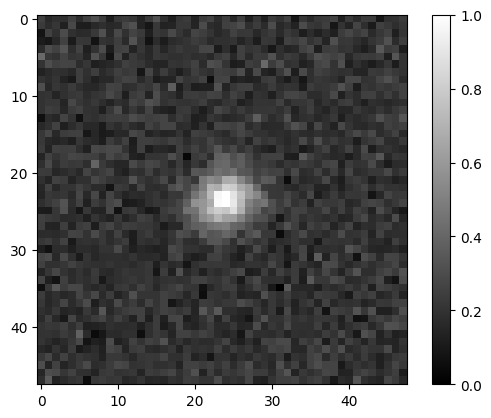

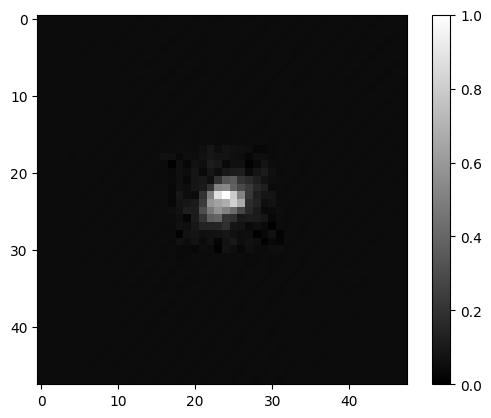

In [62]:
#img_data = np.random.permutation(img_data)
img_data = normalize_list(img_data)
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_split = 0.7
train_idx = int(num_total * train_split)

img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
img_shape = img_data[0].shape

# Spliting training and testing
train = img_data[0:train_idx]
train_x = train[[i for i in range(0, len(train), 2)]]
train_y = train[[i for i in range(1, len(train), 2)]]

test = img_data[train_idx:num_total]
test_x = test[[i for i in range(0, len(test), 2)]]
test_y = test[[i for i in range(1, len(test), 2)]]

idx = 0
show_image(test_x[idx])
show_image(test_y[idx])

In [9]:
resunet_model = resUnet(input_shape=img_shape, num_filters=64, num_resnetblocks=4, kernel_size=3)
resunet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 48, 48, 8)            80        ['input_2[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 48, 48, 8)            32        ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 48, 48, 8)            0         ['batch_normalization_16

In [10]:
resunet_model.compile(optimizer=Adam(), loss='mean_absolute_error', metrics=['mae'])

batch_size = 5
epochs = 20
history = resunet_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_x, test_y))

Epoch 1/20
1400/1400 [==============================] - 42s 27ms/step - loss: 0.0417 - mae: 0.0417 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 2/20
1400/1400 [==============================] - 39s 28ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0273 - val_mae: 0.0273
Epoch 3/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 4/20
1400/1400 [==============================] - 40s 29ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0224 - val_mae: 0.0224
Epoch 5/20
1400/1400 [==============================] - 32s 23ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0224 - val_mae: 0.0224
Epoch 6/20
1400/1400 [==============================] - 37s 26ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.0206 - val_mae: 0.0206
Epoch 7/20
1400/1400 [==============================] - 37s 27ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0164 - val_mae: 0.0164
Epoch 8/20
1400/1400 [==========================

94/94 [==============================] - 2s 20ms/step


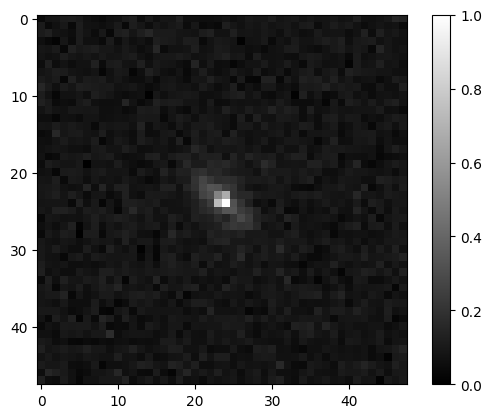

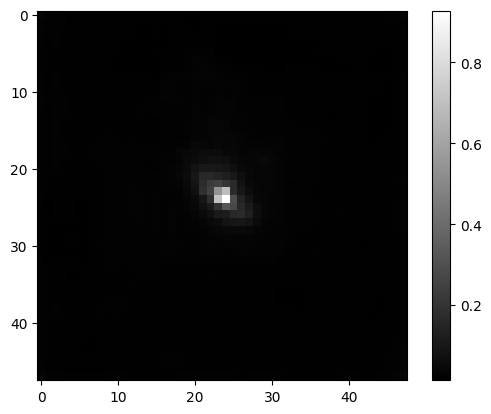

In [11]:
predictions = resunet_model.predict(test_x)
idx = 0
show_image(test_x[idx])
show_image(predictions[idx])

Saving model to file

In [ ]:
resunet_model.save('resunet_100snr2.keras')

**Deconvolution**

Importing images and spliting training and testing datasets

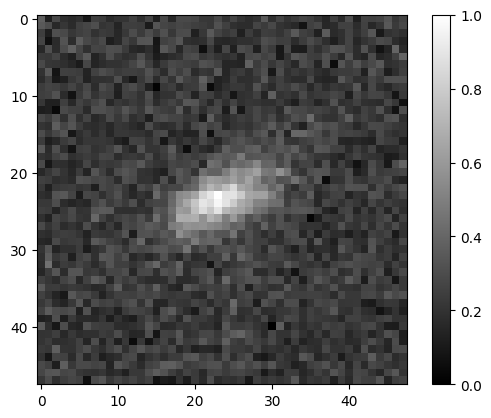

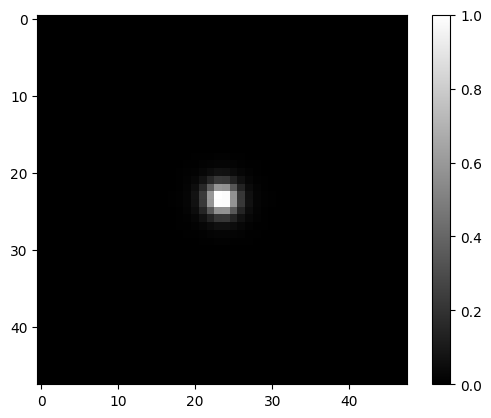

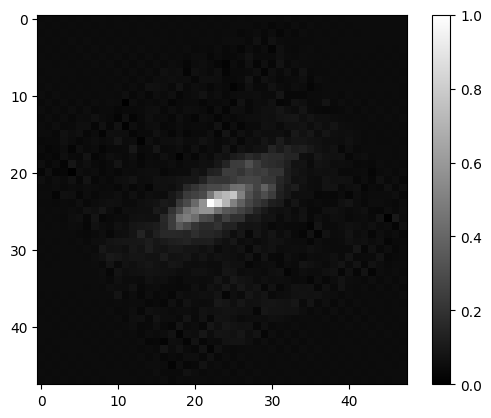

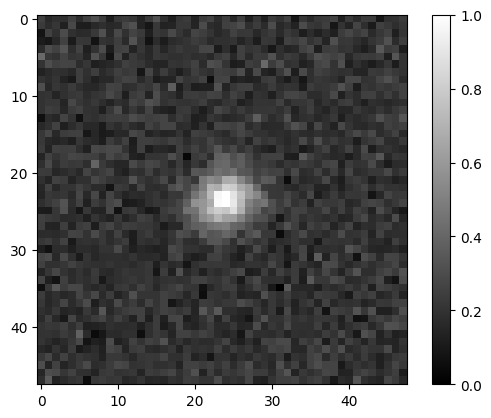

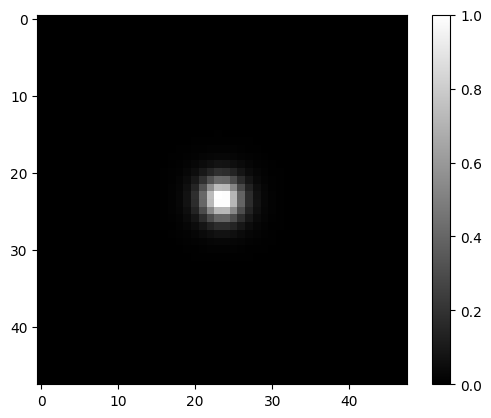

In [66]:
# Importing images
image_file_path = 'outputs/output_deconv_snr100_5k.fits'
img_head, img_data = read_header_and_data(image_file_path, 0) # img_data = [mod_img1, original_img1, mod_img2, original_img2, ...]

image_psf_file_path = 'outputs/output_deconv_snr100_5k_psf.fits'
psf_head, psf_data = read_header_and_data(image_psf_file_path, 0)

# Getting image size
img_size = img_data[0].shape[0]

# Normalizing images
img_data = normalize_list(img_data)
psf_data = normalize_list(psf_data)

# Reshaping images
img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
psf_data = np.array([np.reshape(psf, (img_size, img_size, 1)) for psf in psf_data])
img_shape = img_data[0].shape

# Spliting training and testing
train_split = 0.7
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_idx = int(num_total * train_split)

img_train = img_data[0:train_idx]
psf_train = psf_data[0:train_idx]

img_test = img_data[train_idx:num_total]
psf_test = psf_data[train_idx:num_total]

# Image train
img_train_x = img_train[[i for i in range(0, len(img_train), 2)]]
img_train_y = img_train[[i for i in range(1, len(img_train), 2)]]

# PSF of the train images
psf_train_x = psf_train[[i for i in range(0, len(psf_train), 2)]]

# Image test
img_test_x = img_test[[i for i in range(0, len(img_test), 2)]]
img_test_y = img_test[[i for i in range(1, len(img_test), 2)]]

# PSF of the test images
psf_test_x = psf_test[[i for i in range(0, len(psf_test), 2)]]

idx = 0
show_image(img_train_x[idx])
show_image(psf_train_x[idx])
show_image(img_train_y[idx])
show_image(img_test_x[idx])
show_image(psf_test_x[idx])

Unrolled ADMM Network

In [ ]:
def compute_alpha(N, y, beta=0.33):
    return np.sum(y) / (N*beta)

def unrolled_admm(input_shape, n):
    # Inputs
    y_input = Input(shape=input_shape)
    h_input = Input(shape=input_shape)

    # Get inputs as np objects
    y = tf.keras.backend.eval(y_input) 
    h = tf.keras.backend.eval(h_input)
    
    # Initializing parameters
    N = input_shape[0]
    alpha = compute_alpha(N, y) # 500, 200
    alpha_inv = 1 / alpha

    # Initializing denoising network
    resunet = resUnet(input_shape, num_filters=64, num_resnetblocks=4, kernel_size=3)

    # Initialize x with Wiener Filter
    Y = np.fft.fft(y)
    H = np.fft.fft(h)
    Ht = H.T
    Ht_conj = Ht.conj()
    H_abs_sqr = np.abs(H)**2 # np.linalg.det(H)**2
    x = [alpha_inv * np.fft.ifft((Ht_conj * Y) / (alpha_inv + H_abs_sqr))]

    # Initialize other parameters
    z = [x[0]]
    v = [np.copy(y)]
    u1 = [0]
    u2 = [0]

    # Tilde variables are calculated inside main loop
    x0_tilde = [] 
    x1_tilde = []
    v_tilde = [] 
    z_tilde = []

    # Hyperparameters (can be initialized by nn)
    rho1 = 1 # 10e3 # rho1 in (10−5, 10−2)
    rho2 = 1 # rho2 in ?
    # gamma = 1.5 # gamma in (1, 2)
    # eta = 0.5 # ?

    # ADMM iterations
    for k in range(1, n): # 1..n?
        v_tilde[k-1] = np.convolve(h, x[k-1]) + u2[k-1]
        v[k] = (rho2 * v_tilde[k-1] + y) / (1 + rho2) # gaussian mle

        z_tilde[k-1] = x[k-1] + u1[k-1]
        z[k] = tf.keras.backend.eval(resunet(z_tilde[k-1])) # eq 13

        x0_tilde[k-1] = z[k] - u1[k-1]
        x1_tilde[k-1] = v[k] - u2[k-1]
        X0_tilde = np.fft.fft(x0_tilde[k-1])
        X1_tilde = np.fft.fft(x1_tilde[k-1])
        rho_ratio = rho2 / rho1
        x[k] = np.fft.ifft((X0_tilde + rho_ratio * Ht_conj * X1_tilde) / (1 + rho_ratio * H_abs_sqr)) # eq 12

        # update Lagrangian multipliers
        u1[k] = u1[k-1] + x[k] - z[k] 
        u2[k] = u2[k-1] + np.convolve(H, x[k]) - v[k]

    # Convert processed image back to tensor
    output_img = tf.convert_to_tensor(np.real(x[-1]), dtype=tf.float32) # how to connect

    output = Conv2D(1, 1, activation='sigmoid', padding='same')(output_img)
    network = Model(inputs=[y, h], outputs=output)

    return network


In [ ]:
unrolled_admm_model = unrolled_admm(input_shape=(48, 48, 1), n=8)
unrolled_admm_model.compile(optimizer=Adam(), loss='mean_absolute_error', metrics=['mae'])

batch_size = None # 128
epochs = 25

history = unrolled_admm_model.fit([img_train_x, psf_train_x], img_train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([img_test_x, psf_test_x], img_test_y))

In [98]:
def compute_alpha(N, y, beta=0.33):
    return np.sum(y) / (N*beta)

def unrolled_PNP_ADMM(y, h, n, denoiser):
    # Initializing images
    width, height, channels = y.shape
    y = np.reshape(y, (width, height))
    h = np.reshape(h, (width, height))

    # Initializing parameters
    N = y.shape[0]
    alpha = compute_alpha(N, y) # 500, 200
    alpha_inv = 1 / alpha

    # Initialize x with Wiener Filter
    Y = np.fft.fft2(y)
    H = np.fft.fft2(h)
    Ht = H.T
    Ht_conj = Ht.conj()
    H_abs_sqr = np.abs(H)**2 # np.linalg.det(H)**2
    x = [alpha_inv * np.fft.ifft2((Ht_conj * Y) / (alpha_inv + H_abs_sqr))]

    # Initialize other parameters
    z = [x[0]]
    v = [np.copy(y)]
    u1 = [0]
    u2 = [0]

    # Tilde variables are calculated inside main loop
    x0_tilde = [None] 
    x1_tilde = [None]
    v_tilde = [None] 
    z_tilde = [None]

    # Hyperparameters (can be initialized by nn)
    rho1 = 1 # 10e3 # rho1 in (10−5, 10−2)
    rho2 = 1 # rho2 in ?
    # gamma = 1.5 # gamma in (1, 2)
    # eta = 0.5 # ?

    # ADMM iterations
    for k in range(1, n):
        print(f"it {k}")
        v_tilde[k-1] = np.fft.ifft2(H * np.fft.fft2(x[k-1])) + u2[k-1]  #np.convolve(h, x[k-1]) + u2[k-1]
        v.append((rho2 * v_tilde[k-1] + y) / (1 + rho2)) # gaussian mle

        z_tilde[k-1] = x[k-1] + u1[k-1]
        z.append(denoiser(np.reshape(z_tilde[k-1], (width, height, channels)))) # eq 13

        x0_tilde[k-1] = z[k] - u1[k-1]
        x1_tilde[k-1] = v[k] - u2[k-1]
        X0_tilde = np.fft.fft(x0_tilde[k-1])
        X1_tilde = np.fft.fft(x1_tilde[k-1])
        rho_ratio = rho2 / rho1
        x.append(np.fft.ifft((X0_tilde + rho_ratio * Ht_conj * X1_tilde) / (1 + rho_ratio * H_abs_sqr))) # eq 12

        # update Lagrangian multipliers
        u1.append(u1[k-1] + x[k] - z[k])
        u2.append(u2[k-1] + np.convolve(h, x[k]) - v[k])
    
    output = x[-1]

    return output

idx = 0
img = img_train_x[idx]
psf = psf_train_x[idx]
img_gt = img_train_y[idx]
denoiser = load_model('models/resunet_100snr2.keras')

restored = unrolled_PNP_ADMM(img, psf, n=8, denoiser=denoiser)

show_image(img_gt)
show_image(restored)

it 1


InvalidArgumentError: Exception encountered when calling layer 'concatenate' (type Concatenate).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [48,12,2,128] vs. shape[1] = [48,12,1,64] [Op:ConcatV2] name: concat

Call arguments received by layer 'concatenate' (type Concatenate):
  • inputs=['tf.Tensor(shape=(48, 12, 2, 128), dtype=float32)', 'tf.Tensor(shape=(48, 12, 1, 64), dtype=float32)']

In [80]:
idx = 0
img = img_train_x[idx]
psf = psf_train_x[idx]
img_gt = img_train_y[idx]
denoiser = load_model('models/resunet_100snr2.keras')

restored = unrolled_PNP_ADMM(img, psf, n=8, denoiser=denoiser)

show_image(img_gt)
show_image(restored)

it 1
(48, 48, 1)
(48, 48, 48)


AttributeError: 'int' object has no attribute 'shape'

In [60]:
class unrolledADMM2(Model):
    def __init__(self):
        super().__init__()
        self.denoiser = resUnet(input_shape=(48, 48, 1), num_filters=8, num_resnetblocks=4, kernel_size=3)
    
    def call(self, x):
        img, psf = x
        x = self.denoiser(img)

        return x

In [64]:
unrolled_admm_model = unrolledADMM2()
unrolled_admm_model.compile(optimizer=Adam(), loss='mean_absolute_error', metrics=['mae'])

batch_size = None
epochs = 10

history = unrolled_admm_model.fit([train_x, psf_train_x], train_y, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=([test_x, psf_test_x], test_y))

Epoch 1/10
110/110 [==============================] - 25s 108ms/step - loss: 0.1596 - mae: 0.1596 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 2/10
110/110 [==============================] - 9s 84ms/step - loss: 0.0585 - mae: 0.0585 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 3/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 4/10
110/110 [==============================] - 9s 82ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 5/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 6/10
110/110 [==============================] - 10s 91ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0279 - val_mae: 0.0279
Epoch 7/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0293 - val_mae: 0.0293
Epoch 8/10
110/110 [==============================] - 9s 80ms/step

47/47 [==============================] - 2s 33ms/step


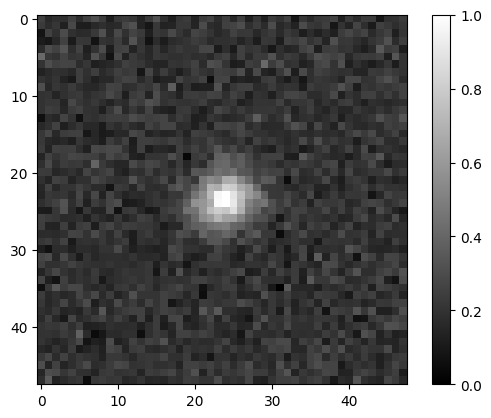

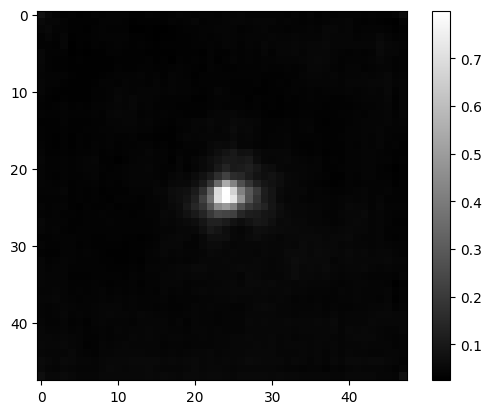

In [65]:
predictions = unrolled_admm_model.predict([img_test_x, psf_test_x])
idx = 0
show_image(img_test_x[idx])
show_image(predictions[idx])